<a href="https://colab.research.google.com/github/Jaeya/pytorch/blob/main/05_pytorch_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치로 구현하는 신경망

## 신경망 모델 구현하기

In [2]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [20]:
n_dim = 2    #2차원
# 80 개의 데이터를 생성
# 차원은 2차원 = > (0.5,0.1) 이런 종류가 80개
# 중심좌표
# shuffle 임의의, 뒤섞는다
# 중심좌표를 기준으로 분포 표준편차(중심좌표에서 어느정도 거리)

# [1,1]좌표 중심 2차원 실수 , 정답 0
# [-1,-1]좌표 중심 2차원 실수 , 정답 1
# [1,-1]좌표 중심 2차원 실수 , 정답 2
# [-1,1]좌표 중심 2차원 실수 , 정답 3

x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

for data in zip(x_train, y_train):
  print(data)

(array([ 0.37004123, -0.74835569]), 2)
(array([0.95819306, 1.22626232]), 0)
(array([1.08014399, 0.95967514]), 0)
(array([-0.98468834, -1.06175799]), 1)
(array([-1.16764678,  0.90735044]), 3)
(array([0.7522738 , 0.73410903]), 0)
(array([1.13436803, 1.34570492]), 0)
(array([-1.23823051,  1.01406461]), 3)
(array([ 1.44209993, -0.65099882]), 2)
(array([-1.34024156, -0.33513172]), 1)
(array([-1.08996093,  0.41630545]), 3)
(array([ 0.76650386, -0.78971904]), 2)
(array([-0.68875263,  0.95195512]), 3)
(array([ 1.11478407, -1.29948908]), 2)
(array([-0.84815054,  1.23231868]), 3)
(array([-1.0569133 ,  1.11603642]), 3)
(array([ 1.12739218, -1.34873502]), 2)
(array([0.58760634, 1.05282304]), 0)
(array([-0.93100061,  1.39996805]), 3)
(array([-0.70682991,  1.40476313]), 3)
(array([-1.26204219, -0.71678886]), 1)
(array([-0.93158513, -0.80016736]), 1)
(array([-0.90359896, -1.25149723]), 1)
(array([ 0.51905579, -0.97011821]), 2)
(array([0.76499711, 0.67257927]), 0)
(array([-0.81906293,  1.10719141]), 3

In [21]:
# 정답을 0, 1 = > 0 축소
# 정답을 2, 3 = > 1 축소

def label_map(y_, from_, to_):
    y = numpy.copy(y_)  # y_ 복제
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

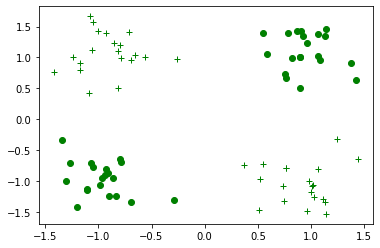

numpy.ndarray

In [31]:
# 우리가 만든 클러스터 점 집합을 화면에 표현
# y가 None이면 점을 모두 * 로 표시
# y가 입력되면 y값이 0이면 o표시 , 1이면 + 출력

def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='g')
plt.show()

type(x_train) 

In [33]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# pytorch의 신경망에 입력하기위해 tensor로 변경
type(x_train)

torch.Size([80, 2])


torch.Tensor

#pytorch에서는 일반적으로 신경망을 설계할 때</br>
#torch.nn.Module을 상속받아서 클래스를 만든다

## 보통 클래스 내에 2개의 메서드를 구현한다
<ol>
  <li>생성자 __init__ : 신경망 구성 정보</li>
  <li>순전파 forward : 신경망 구성</li>
</ol>

In [34]:


class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__() # 서두에 이렇게 부모 생성자를 호출
            self.input_size = input_size      # 입력 크기
            self.hidden_size  = hidden_size   # 은닉층 크기
            
            # 일반적인 fc(fully connection) / Dense(밀집층)
            # 입력 -> 은닉
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()       # 활성화 함수 Relu
            # 은닉 -> 출력 1개 
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            # 정답이 0, 1 두개이므로 시그모이드를 사용함
            self.sigmoid = torch.nn.Sigmoid()


        # 순전파 메서드   
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)   # 입력값 -> 입력층 -> 은닉층
            relu = self.relu(linear1)               # 은닉층을 거친 값에 Relu적용
            linear2 = self.linear_2(relu)           # 은닉층 -> 출력
            output = self.sigmoid(linear2)          # 출력층이 시그모이드를 통과
            return output

In [8]:
model = NeuralNet(2, 5)    # 생성자 __init__ 호출
learning_rate = 0.03
criterion = torch.nn.BCELoss()  # Binary Cross Entropy , 분류
epochs = 2000
# SGD(Stochatic Gradient Descent) : 확률적 경사하강법
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [38]:
# 학습을 하지 않은 상태에서 모델의 성능을 시험한다

model.eval() # 시험모드로 전환
output = model(x_test)  # model(x_test)  ==> model.forward(x_test)을 호출한 것이다
output = output.squeeze() # 출력층의 차원을 1차원 감소한다
test_loss_before = criterion(output, y_test) # 오차값을 얻는다
# test_loss_before는 tensor객체이므로 , 일반 Scalar값(변수값)으로 얻기 위해 test_loss_before.item()으로 호출해준다
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.3839067816734314


오차값이 0.73 이 나왔습니다. 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방합니다.
자, 이제 드디어 인공신경망을 학습시켜 퍼포먼스를 향상시켜 보겠습니다.

In [39]:
for epoch in range(epochs):
    model.train()           # 학습모드로 전환
    optimizer.zero_grad()   # 기울기를 0으로 초기화
    train_output = model(x_train)  # model.forward(x_train) - 순전파
    train_loss = criterion(train_output.squeeze(), y_train) # 오차값
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()    # 오차역전파 == 오차값을 각 레이어에 전달
    optimizer.step()         # 학습 - lr과 기울기로 w, b를 수정

Train loss at 0 is 0.3876282572746277
Train loss at 100 is 0.3786921203136444
Train loss at 200 is 0.37382078170776367
Train loss at 300 is 0.3717566132545471
Train loss at 400 is 0.36984387040138245
Train loss at 500 is 0.3680359721183777
Train loss at 600 is 0.3663173317909241
Train loss at 700 is 0.364685595035553
Train loss at 800 is 0.36319684982299805
Train loss at 900 is 0.3618163466453552
Train loss at 1000 is 0.360714852809906
Train loss at 1100 is 0.35975614190101624
Train loss at 1200 is 0.358876496553421
Train loss at 1300 is 0.3580726981163025
Train loss at 1400 is 0.35733622312545776
Train loss at 1500 is 0.3567250370979309
Train loss at 1600 is 0.3561871647834778
Train loss at 1700 is 0.35570278763771057
Train loss at 1800 is 0.3552592098712921
Train loss at 1900 is 0.3548586964607239


In [11]:
model.eval()  # 시험모드로 전환
# 시험데이터 입력값과 시험데이터 정답을 비교해서 오차를 얻는다
test_loss = criterion(model(x_test).squeeze(), y_test) 
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.382001668214798


학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인 하실 수 있습니다.
지금까지 인공신경망을 구현하고 학습시켜 보았습니다.
이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [12]:
# 모델을 파일로 저장한다
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 0.4637,  0.1238],
        [-0.0423, -0.0868],
        [-0.6718,  1.3319],
        [-0.5255,  1.2008],
        [ 1.2976,  1.6449]])), ('linear_1.bias', tensor([-0.6785, -0.1875, -0.3814, -0.1019, -0.4043])), ('linear_2.weight', tensor([[-0.2072,  0.3519,  1.4159,  0.9488, -2.0666]])), ('linear_2.bias', tensor([0.0115]))])


`save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [46]:
# 같은 노드를 보유한 새로운 객체 생성
new_model = NeuralNet(2, 5)
# 기존 학습된 모델정보를 적용해준다
new_model.load_state_dict(torch.load('./model.pt'))
# 바로 시험에 들어간다
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))


벡터 [-1, 1]이 레이블 1을 가질 확률은 0.9791628122329712
